In [1]:
import rasterio
from rasterio.mask import mask

# Paths
dem_hr_path = '/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/Krycklan_2015_DEM_0.5m/Krycklan_2015_DEM_cleaned.tif'
clip_raster_path = '/Users/jpnousu/Krycklan_GIS_data/20m/C20/dem_clip.tif'
output_path = '/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/Krycklan_2015_DEM_0.5m/Krycklan_2015_DEM_cleaned_C20.tif'

# Open the clip raster to get its geometry
with rasterio.open(clip_raster_path) as clip_src:
    clip_bounds = clip_src.bounds
    clip_crs = clip_src.crs

# Open the high-res DEM
with rasterio.open(dem_hr_path) as dem_src:
    # Ensure the CRS matches
    if dem_src.crs != clip_crs:
        raise ValueError("CRS of DEM and clip raster do not match!")

    # Define bounding box geometry as a GeoJSON-like dict
    from shapely.geometry import box
    import geopandas as gpd

    bbox_geom = box(*clip_bounds)
    bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_geom]}, crs=clip_crs)
    geoms = [feature["geometry"] for feature in bbox_gdf.__geo_interface__["features"]]

    # Mask and crop DEM
    out_image, out_transform = mask(dem_src, geoms, crop=True)
    out_meta = dem_src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Save clipped and masked DEM
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(out_image)

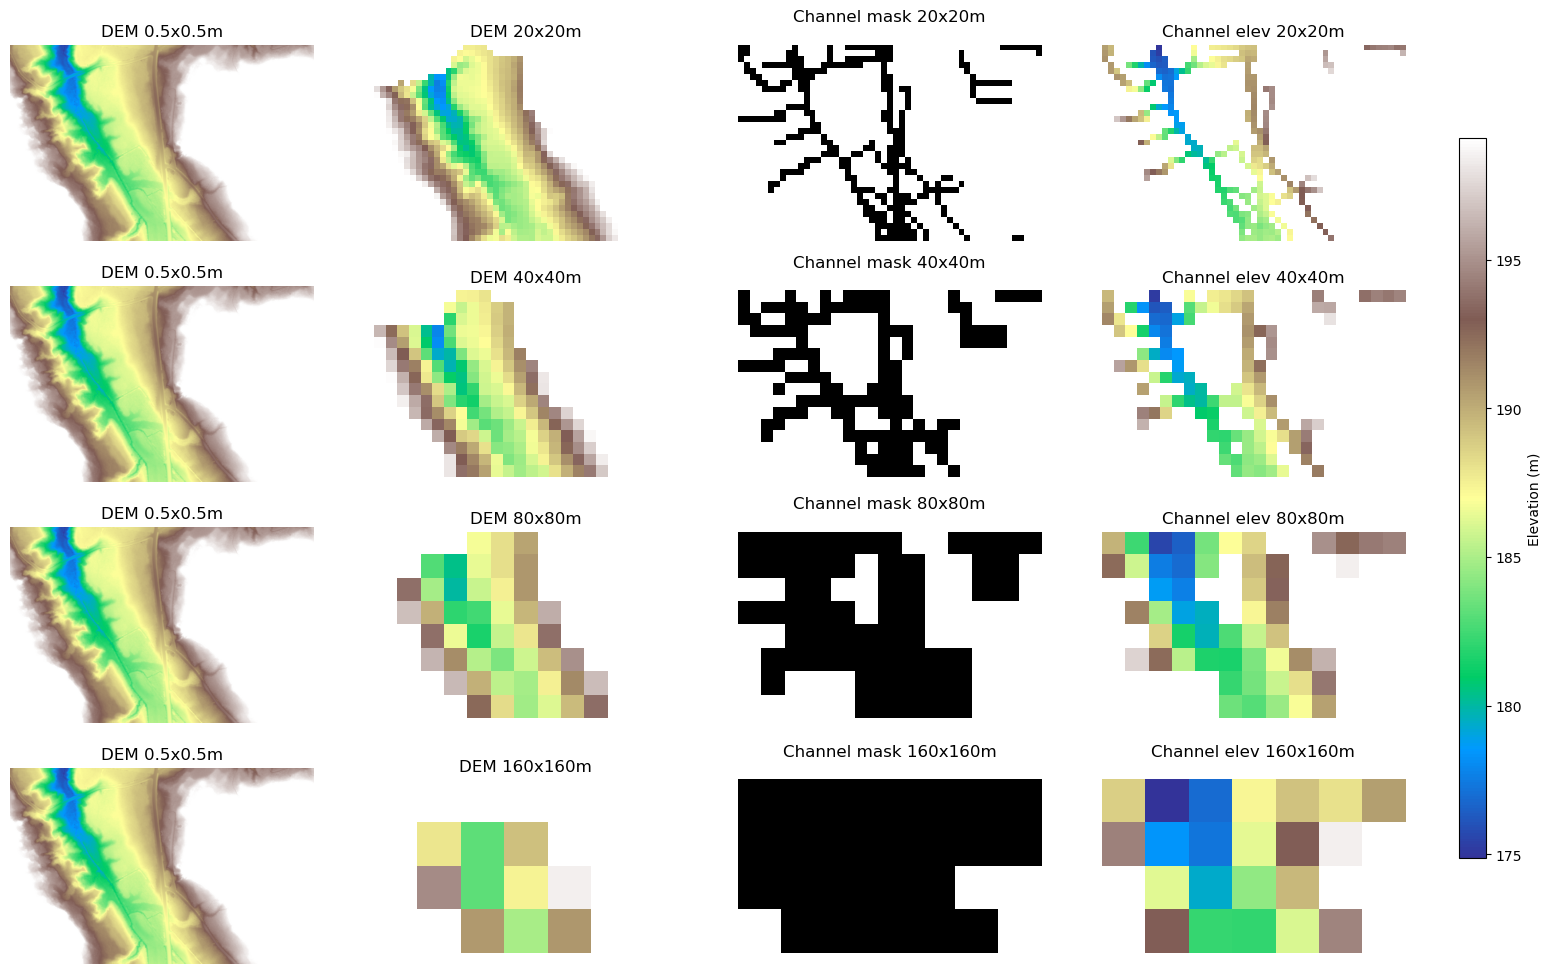

In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

resos = [20, 40, 80, 160]
dem_h_f = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/Krycklan_2015_DEM_0.5m/Krycklan_2015_DEM_cleaned_C20.tif'

# ---- Custom crop: middle in X, top in Y ----
def crop_custom(array, src, frac_x=0.5, frac_y=0.5):
    """Crop raster: middle frac_x in X, upper frac_y in Y."""
    rows, cols = array.shape

    # Y (rows): take top frac_y
    rmin = 0
    rmax = int(rows * frac_y)

    # X (cols): take middle frac_x
    cmin = int(cols * (1 - frac_x) / 2)
    cmax = int(cols * (1 + frac_x) / 2)

    cropped = array[rmin:rmax, cmin:cmax]

    # Compute new extent
    xmin, ymax = src.xy(rmin, cmin)
    xmax, ymin = src.xy(rmax, cmax)
    extent = (xmin, xmax, ymin, ymax)

    return cropped, extent

# --- High-res DEM defines colormap range ---
with rasterio.open(dem_h_f) as src:
    dem_h = src.read(1)
    dem_h = np.where(dem_h == src.nodata, np.nan, dem_h)
    dem_h, extent_h = crop_custom(dem_h, src, frac_x=0.5, frac_y=0.5)
    dem_min, dem_max = np.nanmin(dem_h), np.nanmax(dem_h)
    dem_max -= 30
    #dem_min += 10

# --- Create figure with 4 rows × 4 cols ---
fig, axes = plt.subplots(len(resos), 4, figsize=(18, 12))
cmap_dem = "terrain"

# Colormap for channel mask (binary)
cmap_mask = ListedColormap(["white", "black"])
norm_mask = BoundaryNorm([0, 1, 2], cmap_mask.N)

for i, reso in enumerate(resos):
    # Low-res DEM
    dem_x_f = f'/Users/jpnousu/Krycklan_GIS_data/{reso}m/C20/dem_clip.tif'
    with rasterio.open(dem_x_f) as src:
        dem_x = np.where(src.read(1) == src.nodata, np.nan, src.read(1))
        dem_x, extent_x = crop_custom(dem_x, src, frac_x=0.5, frac_y=0.5)

    # Channel mask
    chan_m_f = f'/Users/jpnousu/Krycklan_GIS_data/{reso}m/C20/channels.asc'
    with rasterio.open(chan_m_f) as src:
        chanm = np.where(src.read(1) == src.nodata, 0, src.read(1))
        chanm, extent_m = crop_custom(chanm, src, frac_x=0.5, frac_y=0.5)

    # Channel elevation
    chan_e_f = f'/Users/jpnousu/Krycklan_GIS_data/{reso}m/C20/channels_elev.asc'
    with rasterio.open(chan_e_f) as src:
        chan = np.where(src.read(1) == src.nodata, np.nan, src.read(1))
        chan, extent_c = crop_custom(chan, src, frac_x=0.5, frac_y=0.5)

    # Plot high-res DEM
    axes[i, 0].imshow(dem_h, extent=extent_h, cmap=cmap_dem, origin="upper",
                      vmin=dem_min, vmax=dem_max)
    axes[i, 0].set_title("DEM 0.5x0.5m")
    axes[i, 0].axis("off")

    # Plot low-res DEM
    axes[i, 1].imshow(dem_x, extent=extent_x, cmap=cmap_dem, origin="upper",
                      vmin=dem_min, vmax=dem_max)
    axes[i, 1].set_title(f"DEM {reso}x{reso}m")
    axes[i, 1].axis("off")

    # Plot channel mask
    axes[i, 2].imshow(chanm, extent=extent_m, cmap=cmap_mask, norm=norm_mask, origin="upper")
    axes[i, 2].set_title(f"Channel mask {reso}x{reso}m")
    axes[i, 2].axis("off")

    # Plot channel elevation
    im = axes[i, 3].imshow(chan, extent=extent_c, cmap=cmap_dem, origin="upper",
                           vmin=dem_min, vmax=dem_max)
    axes[i, 3].set_title(f"Channel elev {reso}x{reso}m")
    axes[i, 3].axis("off")

# Shared colorbar
cbar_ax = fig.add_axes([0.93, 0.2, 0.015, 0.6])
fig.colorbar(im, cax=cbar_ax, orientation="vertical", label="Elevation (m)")

#plt.tight_layout(rect=[0, 0, 0.92, 1])
#plt.savefig("figs/dem_channel_comparison.png", dpi=300, bbox_inches="tight")
#plt.close()

In [26]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

resos = [20, 40, 80, 160]
dem_h_f = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/Krycklan_2015_DEM_0.5m/Krycklan_2015_DEM_cleaned_C20.tif'

# ---- Custom crop: middle in X, top in Y ----
def crop_custom(array, src, frac_x=0.5, frac_y=0.5):
    """Crop raster: middle frac_x in X, upper frac_y in Y."""
    rows, cols = array.shape

    # Y (rows): take top frac_y
    rmin = 0
    rmax = int(rows * frac_y)

    # X (cols): take middle frac_x
    cmin = int(cols * (1 - frac_x) / 2)
    cmax = int(cols * (1 + frac_x) / 2)

    cropped = array[rmin:rmax, cmin:cmax]

    # Compute new extent
    xmin, ymax = src.xy(rmin, cmin)
    xmax, ymin = src.xy(rmax, cmax)
    extent = (xmin, xmax, ymin, ymax)

    return cropped, extent

# --- High-res DEM defines colormap range ---
with rasterio.open(dem_h_f) as src:
    dem_h = src.read(1)
    dem_h = np.where(dem_h == src.nodata, np.nan, dem_h)
    dem_h, extent_h = crop_custom(dem_h, src, frac_x=0.5, frac_y=0.5)
    dem_min, dem_max = np.nanmin(dem_h), np.nanmax(dem_h)
    dem_max -= 30

# --- Create figure with 4 rows × 5 cols ---
fig, axes = plt.subplots(len(resos), 5, figsize=(22, 12))
cmap_dem = "terrain"

# Colormap for channel mask (binary)
cmap_mask = ListedColormap(["white", "black"])
norm_mask = BoundaryNorm([0, 1, 2], cmap_mask.N)

for i, reso in enumerate(resos):
    # Low-res DEM
    dem_x_f = f'/Users/jpnousu/Krycklan_GIS_data/{reso}m/C20/dem_clip.tif'
    with rasterio.open(dem_x_f) as src:
        dem_x = np.where(src.read(1) == src.nodata, np.nan, src.read(1))
        dem_x, extent_x = crop_custom(dem_x, src, frac_x=0.5, frac_y=0.5)

    # Channel mask
    chan_m_f = f'/Users/jpnousu/Krycklan_GIS_data/{reso}m/C20/channels.asc'
    with rasterio.open(chan_m_f) as src:
        chanm = np.where(src.read(1) == src.nodata, 0, src.read(1))
        chanm, extent_m = crop_custom(chanm, src, frac_x=0.5, frac_y=0.5)

    # Channel elevation
    chan_e_f = f'/Users/jpnousu/Krycklan_GIS_data/{reso}m/C20/channels_elev.asc'
    with rasterio.open(chan_e_f) as src:
        chan = np.where(src.read(1) == src.nodata, np.nan, src.read(1))
        chan, extent_c = crop_custom(chan, src, frac_x=0.5, frac_y=0.5)

    # Compute channel depth
    depth = chan - dem_x

    # Plot high-res DEM only for the first row
    if i == 0:
        axes[i, 0].imshow(dem_h, extent=extent_h, cmap=cmap_dem, origin="upper",
                          vmin=dem_min, vmax=dem_max)
        axes[i, 0].set_title("DEM 0.5x0.5m")
    axes[i, 0].axis("off")  # keep empty for other rows

    # Plot low-res DEM
    axes[i, 1].imshow(dem_x, extent=extent_x, cmap=cmap_dem, origin="upper",
                      vmin=dem_min, vmax=dem_max)
    axes[i, 1].set_title(f"DEM {reso}x{reso}m")
    axes[i, 1].axis("off")

    # Plot channel mask
    axes[i, 2].imshow(chanm, extent=extent_m, cmap=cmap_mask, norm=norm_mask, origin="upper")
    axes[i, 2].set_title(f"Channel mask {reso}x{reso}m")
    axes[i, 2].axis("off")

    # Plot channel elevation
    im_chan = axes[i, 3].imshow(chan, extent=extent_c, cmap=cmap_dem, origin="upper",
                                vmin=dem_min, vmax=dem_max)
    axes[i, 3].set_title(f"Channel elev {reso}x{reso}m")
    axes[i, 3].axis("off")

    # Plot channel depth
    im_depth = axes[i, 4].imshow(depth, extent=extent_x, cmap="viridis", origin="upper")
    axes[i, 4].set_title(f"Channel elev-DEM {reso}x{reso}m")
    axes[i, 4].axis("off")

# Shared colorbar for DEM/elevation
cbar_ax = fig.add_axes([-0.04, 0.76, 0.01, 0.2])
fig.colorbar(im_chan, cax=cbar_ax, orientation="vertical", label="Elevation (m)")

# Separate colorbar for channel depth
cbar_ax2 = fig.add_axes([0.9, 0.76, 0.01, 0.2])
fig.colorbar(im_depth, cax=cbar_ax2, orientation="vertical", label="Channel depth (m)")

plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.savefig("figs/dem_channel_comparison_with_depth.png", dpi=300, bbox_inches="tight")
plt.close()

/var/folders/01/f14lxpfj5wl28zjtf5rz8t9c0000gn/T/ipykernel_79754/2480798702.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])
